In [1]:
from pathlib import Path
from typing import NamedTuple, Tuple

import psyplot.project as psy
import pandas as pd
from psy_strat.stratplot import stratplot
import matplotlib as mpl
import matplotlib.pyplot as plt

Note: this notebook uses the environment `as_data_minimal`

In [2]:
mpl.rcParams['figure.figsize'] = (18, 10)
mpl.rcParams['figure.dpi'] = 150

In [3]:
DATA_DIR = Path('../outputs')

In [4]:
PLOTS_DIR = Path('../outputs/plots')

In [5]:
pollen_df = pd.read_csv(DATA_DIR / 'site_pollen_abundance_ts.csv')
group_df = pd.read_csv(DATA_DIR / 'pollen_groups.csv')

In [6]:
pollen_df.head()

,sitename,sigle,sample_,varcode,agebp,count,varname,site_,e_,chron_,var_
0,Algendar,ALGENDAR,1,Bux,2262.0,3.0,Buxus,55,56,1,119
1,Algendar,ALGENDAR,1,Crl-T,2262.0,1.0,Cerealia-type,55,56,1,165
2,Algendar,ALGENDAR,1,Cheae,2262.0,57.0,Chenopodiaceae,55,56,1,185
3,Algendar,ALGENDAR,1,Ciu,2262.0,3.0,Cistus,55,56,1,196
4,Algendar,ALGENDAR,1,Cm.Sf.A,2262.0,11.0,Compositae subf. Asteroideae,55,56,1,201


In [7]:
group_df.head()

,var_,groupid,groupname
0,1,TRSH,Trees and shrubs
1,2,TRSH,Trees and shrubs
2,3,TRSH,Trees and shrubs
3,4,TRSH,Trees and shrubs
4,5,TRSH,Trees and shrubs


In [8]:
df = pollen_df.merge(group_df, how='left', on='var_')

In [9]:
df['groupname'].unique()

array(['Trees and shrubs', 'Herbs', 'Dwarf shrubs', 'Helophytes',
       'Vascular cryptogams (Pteridophytes)', 'Algae', 'Aquatics',
       'Dinoflagellates', 'Bryophytes', 'Nonpollen',
       'Indeterminables and unknowns', 'Fungi', 'Pre-Quaternary type',
       'Cyanobacteria', 'Nematoda (roundworms)', 'Aquatic Pteridophyta',
       'Microcrustaceans', 'Invertebrates', 'Undifferentiated NPP',
       'Rhizopods', 'Macrofossils', 'Acritarchs'], dtype=object)

Assumptions:
- Undifferentiated NPP is NPP-ID: Non-Pollen Palynomorph
- Exclude Nonpollen, Cyanobacteria, Microcrustaceans, Invertebrates, Nematoda (roundworms), Macrofossils, Acritarchs, Rhizopods, Indeterminables and unknowns

In [10]:
excluded_types = [
    'Nonpollen',
    'Cyanobacteria',
    'Microcrustaceans',
    'Invertebrates',
    'Nematoda (roundworms)',
    'Macrofossils',
    'Acritarchs',
    'Rhizopods',
    'Indeterminables and unknowns',
    'Undifferentiated NPP'
]

In [11]:
df = (
    df[~df['groupname'].isin(excluded_types)]
    .loc[:, ['sitename', 'varname', 'groupname', 'agebp', 'count']]
)

In [12]:
def get_grouper(sitename):
    def grouper(col):
        return (
            df[df['sitename'] == sitename][['varname', 'groupname']]
            .drop_duplicates().set_index('varname')['groupname']
            .loc[col]
        )
    return grouper

In [13]:
def grouper(col):
    return (
        df[['varname', 'groupname']]
        .drop_duplicates().set_index('varname')['groupname']
        .loc[col]
    )

Navarres and Charco da Candieira have some duplicated rows with common (sitename, agebp, and varname).

In [14]:
df[df.loc[:, ['sitename', 'agebp', 'varname', 'count']].duplicated(subset=['sitename', 'agebp', 'varname'])]['sitename'].unique()

array(['Navarrés', 'Charco da Candieira'], dtype=object)

Examining these in more detail

In [15]:
(
    df[
        df.loc[:, ['sitename', 'agebp', 'varname', 'count']]
        .duplicated(subset=['sitename', 'agebp', 'varname'], keep=False)
    ]
    .sort_values(by=['sitename', 'agebp', 'varname'])
)

,sitename,varname,groupname,agebp,count
16283,Charco da Candieira,Alnus glutinosa,Trees and shrubs,1411.0,3.0
16332,Charco da Candieira,Alnus glutinosa,Trees and shrubs,1411.0,4.0
16284,Charco da Candieira,Anthemis-type,Herbs,1411.0,2.0
16333,Charco da Candieira,Anthemis-type,Herbs,1411.0,2.0
16285,Charco da Candieira,Armeria,Herbs,1411.0,3.0
...,...,...,...,...,...
5498,Navarrés,Labiatae (6),Herbs,3259.0,1.0
4706,Navarrés,Quercus ilex-type,Trees and shrubs,3259.0,59.0
5482,Navarrés,Quercus ilex-type,Trees and shrubs,3259.0,45.0
4707,Navarrés,Quercus robur-type,Trees and shrubs,3259.0,4.0


These duplicated values should either be summed, or one selected over the other. Assume for the time being that they should be summed

In [16]:
plot_df = df.groupby(['sitename', 'agebp', 'varname'])['count'].sum().unstack()

In [17]:
# group2taxon = pd.DataFrame.from_dict(plot_df.groupby(grouper, axis=1).groups, orient='index').T
# group2taxon.fillna('')

In [18]:
class SitePlotMeta(NamedTuple):
    name: str
    pollen_width: float
    figsize: Tuple[int, int]
    min_date: int
    max_date: int

In [31]:
def generate_pollen_diagram(df: pd.DataFrame, site_meta: SitePlotMeta):
    mpl.rcParams['figure.figsize'] = site_meta.figsize
    # mpl.rcParams['figure.dpi'] = 150
    # _, ax = plt.subplots(figsize=site_meta.figsize)
    sub_df = df.loc[
        pd.IndexSlice[site_meta.name, site_meta.min_date:site_meta.max_date], :
    ].droplevel(0).dropna(axis=1, how='all')
    sp, groupers = stratplot(
        sub_df,
        get_grouper(site_meta.name),
        # ax=ax,
        # plot_df.loc[site_meta.name].dropna(axis=1, how='all'), get_grouper(site_meta.name),
        thresh=4.0,
        widths={'Pollen': site_meta.pollen_width},
        percentages=['Pollen'],
        subgroups={'Pollen': ['Trees and shrubs', 'Dwarf shrubs', 'Herbs']},
        exclude=[
            'Helophytes',
            'Vascular cryptogams (Pteridophytes)',
            'Algae',
            'Aquatics',
            'Dinoflagellates',
            'Bryophytes',
            'Pre-Quaternary type',
            'Fungi',
            'Aquatic Pteridophyta'
        ],
    )
    # ax.set_ylim(site_meta.min_date, site_meta.max_date)
    plt.savefig(PLOTS_DIR / f'{site_meta.name.lower()}_pollen_diagram.png', bbox_inches='tight', dpi=150)

In [34]:
sites_metas = [
    SitePlotMeta('Algendar', 1.1, (18, 10), 2000, 9000),
    SitePlotMeta('Atxuri', 1.1, (18, 10), 0, 6500),
    SitePlotMeta('Charco da Candieira', 1.1, (18, 10), -50, 12600),
    SitePlotMeta('Monte Areo mire', 1.1, (18, 10), 0, 11000),
    SitePlotMeta('Navarrés', 1.1, (18, 10), 2500, 31000),
    SitePlotMeta('San Rafael', 1.1, (18, 10), 0, 17500),
]

/opt/miniconda3/envs/as_data_minimal/lib/python3.9/site-packages/psy_strat/stratplot.py:182: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df[norm_members].fillna(0).sum(axis=1)[:, np.newaxis],
/opt/miniconda3/envs/as_data_minimal/lib/python3.9/site-packages/psy_strat/stratplot.py:182: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df[norm_members].fillna(0).sum(axis=1)[:, np.newaxis],
/opt/miniconda3/envs/as_data_minimal/lib/python3.9/site-packages/psy_strat/stratplot.py:182: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df[norm_members].fillna(0).sum(axis=1)[:, np.newaxis],
/opt

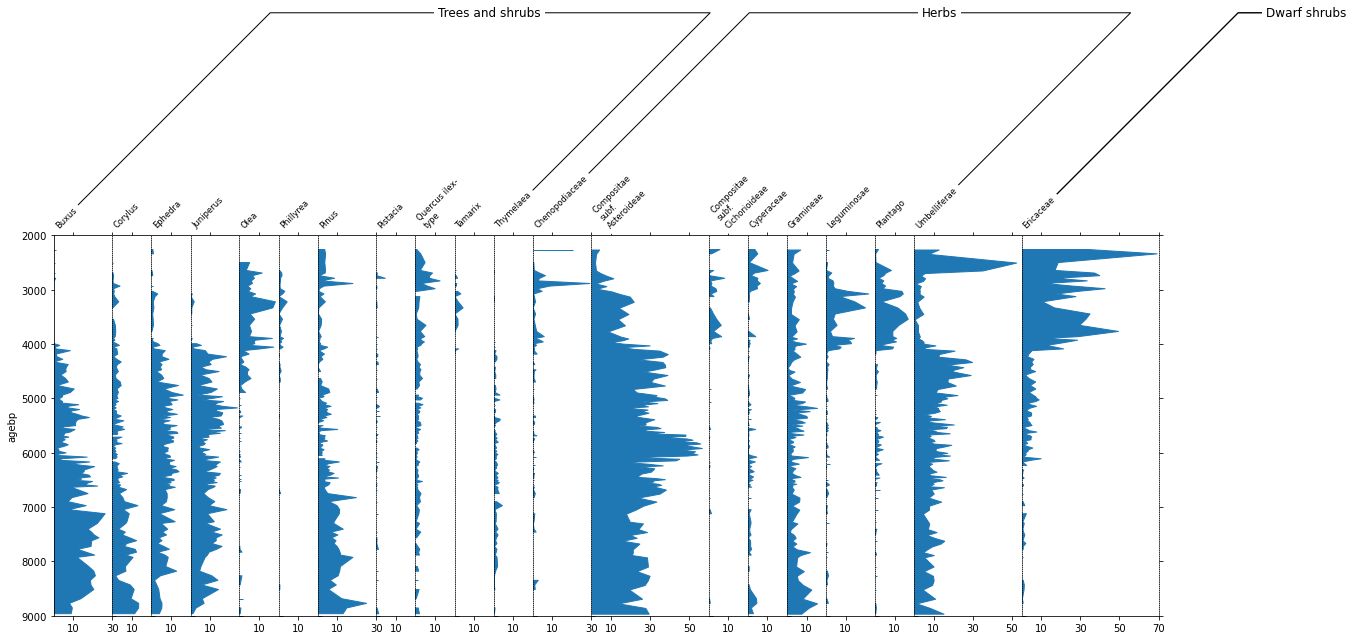

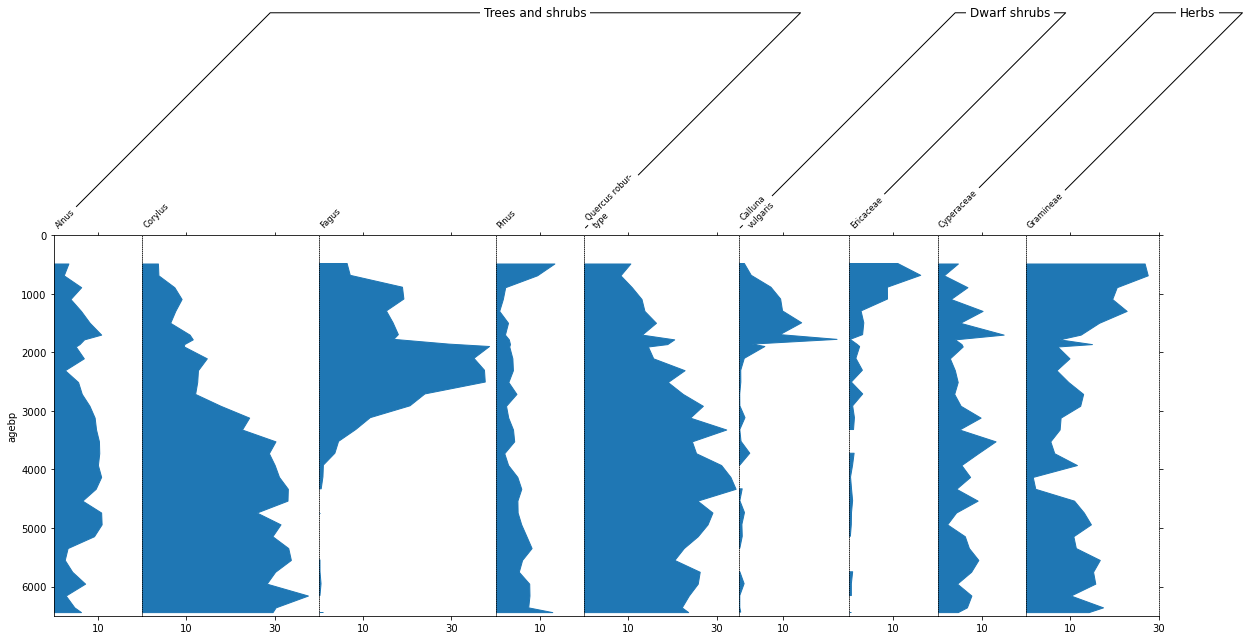

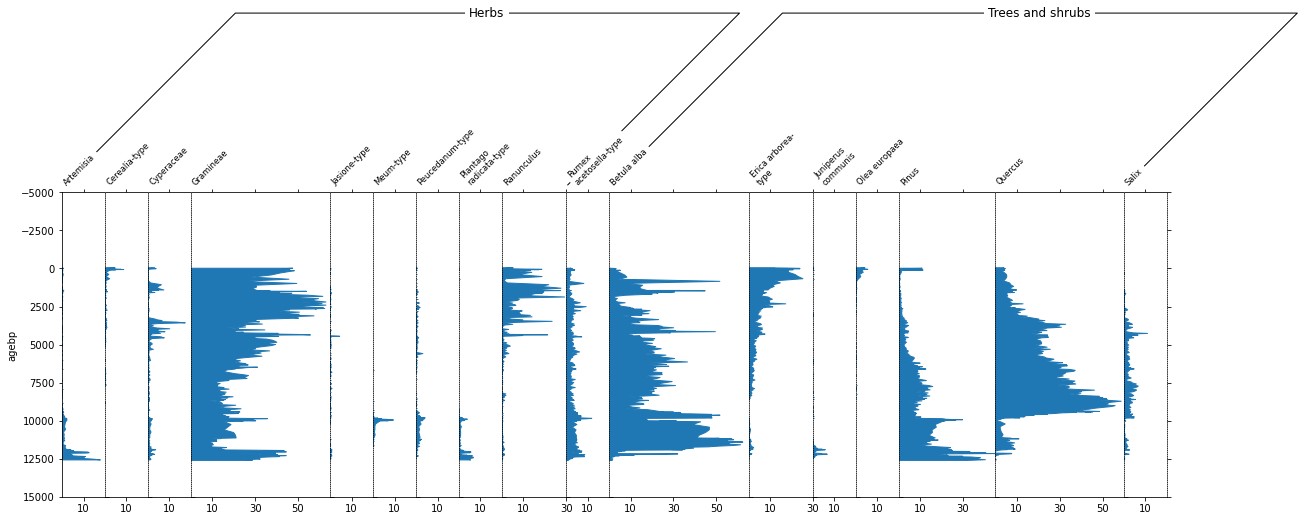

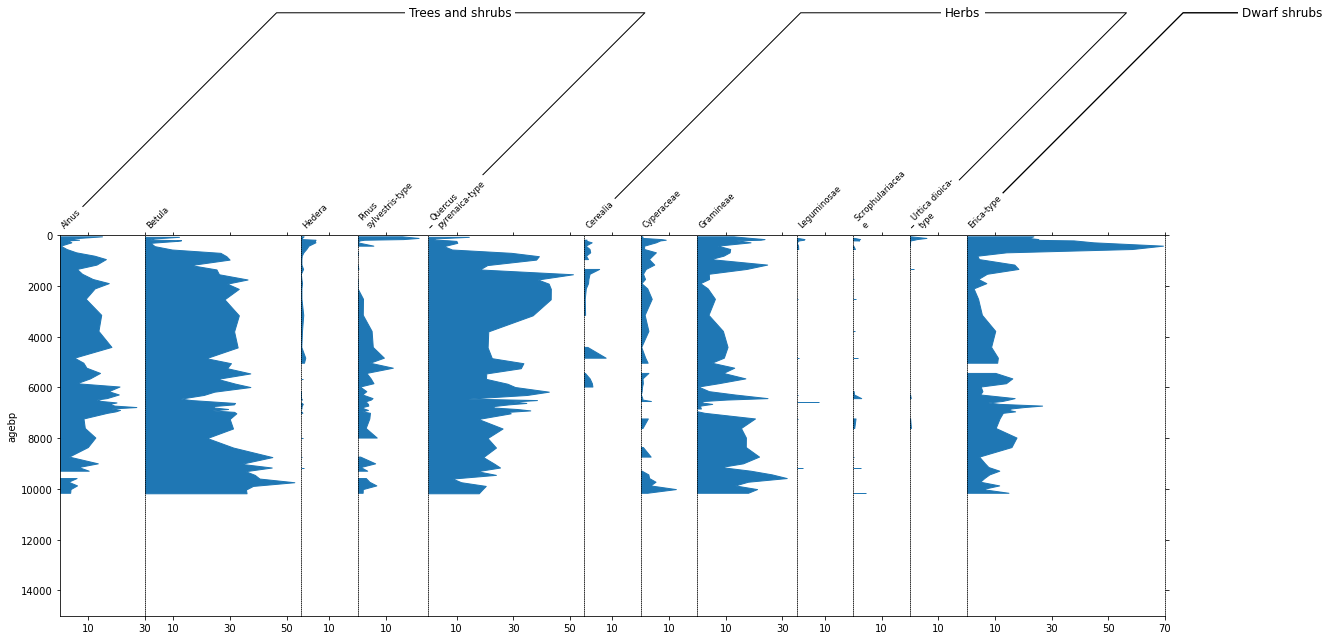

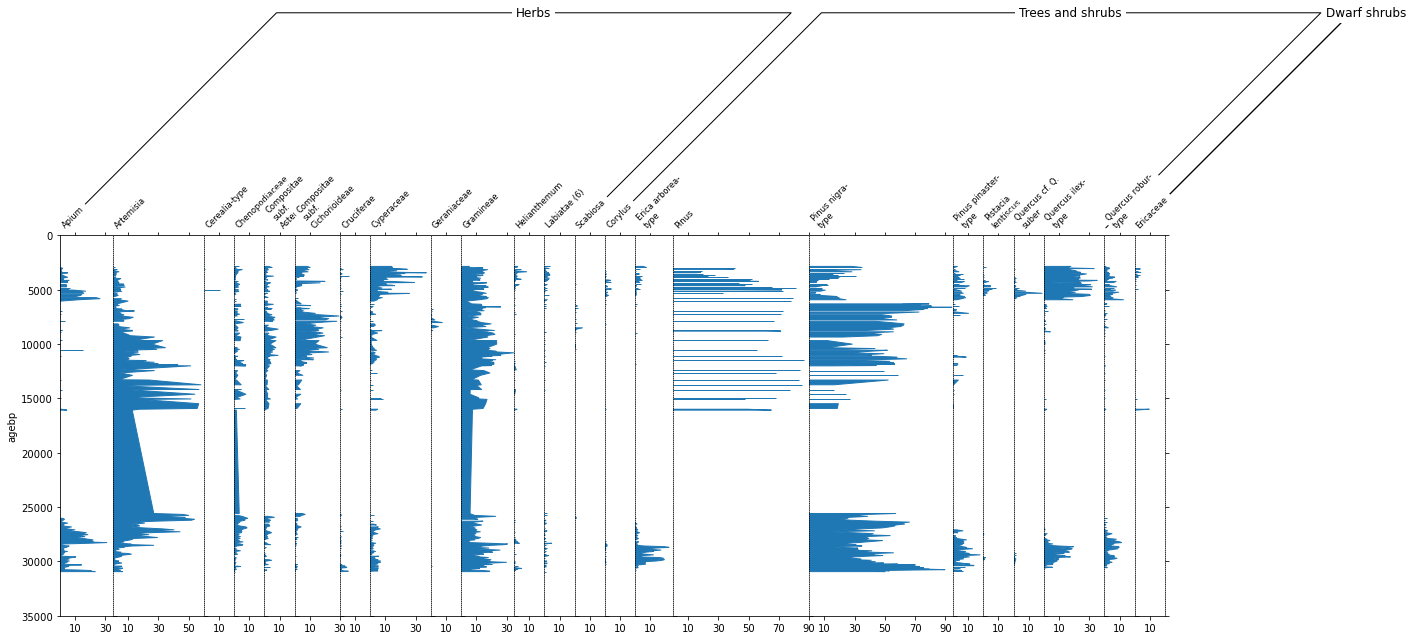

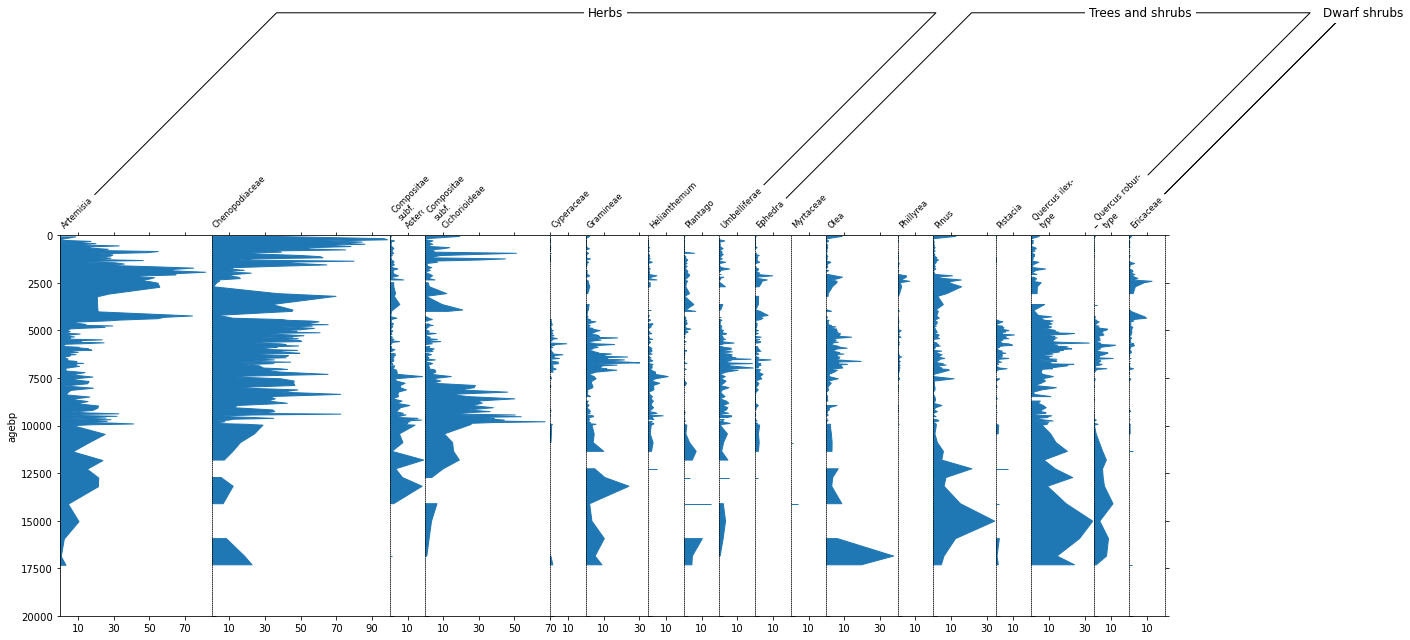

In [35]:
for sm in sites_metas:
    generate_pollen_diagram(plot_df, sm)

In [ ]:
def generate_pollen_diagram_legacy(df: pd.DataFrame, sitename: str):
    mpl.rcParams['figure.figsize'] = (18, 10)
    mpl.rcParams['figure.dpi'] = 150
    sp, groupers = stratplot(
        # plot_df.loc[
        #     pd.IndexSlice[site_meta.name, site_meta.min_date:site_meta.max_date], :
        # ].dropna(axis=1, how='all'), get_grouper(site_meta.name),
        df.loc[sitename].dropna(axis=1, how='all'), get_grouper(sitename),
        thresh=2.0,
        widths={'Pollen': 1.1},
        percentages=['Pollen'],
        subgroups={'Pollen': ['Trees and shrubs', 'Dwarf shrubs', 'Herbs']},
        exclude=[
            'Helophytes',
            'Vascular cryptogams (Pteridophytes)',
            'Algae',
            'Aquatics',
            'Dinoflagellates',
            'Bryophytes',
            'Pre-Quaternary type',
            'Fungi',
            'Aquatic Pteridophyta'
        ],
    )
    plt.savefig(PLOTS_DIR / f'{sitename.lower()}_pollen_diagram.png', bbox_inches='tight')

In [ ]:
for sitename in plot_df.index.get_level_values(0).unique():
    generate_pollen_diagram_legacy(plot_df, sitename)